# Wind and Solar Suitability Analysis

### Scientific Question Addressed: 
If DAC areas, important farmland, and all areas within proximity to natural areas are excluded from siting, how much land is available for siting? Is there enough land available to reach clean grid goals given capacity expansion projections?

### This notebook calculates the following items referenced in the paper:

* Available Land by State for Wind and Solar under Baseline Exclusions
* Available Land by State for Wind and Solar under Baseline Exclusions + Exclusion of DAC areas
* Available Land by State for Wind and Solar under Baseline Exclusions + Exclusion of Important Farmland areas 
* Available Land by State for Wind and Solar under Baseline Exclusions + Exclusion of Areas Surrounding Natural Areas (1, 5, 10km distance)
* Available Land by State for Wind and Solar under Baseline Exclusions + Exclusion of DAC areas, Important Farmland, and Areas within 5km of Natural Areas 
* Available Land by State for Wind and Solar under Baseline Exclusions + Exclusion of Important Farmland and Areas within 5km of Natural Areas 
* Available Land by State for Wind and Solar under Baseline Exclusions + Exclusion of Important Farmland and Areas within 10km of Natural Areas 


## Raster Data

Most of the raster data used for this analysis is from the GRIDCERF geospatial database v1.0.0, accessible at https://zenodo.org/records/6601790. Additional raster data from GRICERF v2.0.0 was used to supplement the dataset, accessible at: https://doi.org/10.57931/2281697.To prepare data for analysis, all raster data is clipped to the western interconnection boundary extent.

For information on the specific data layers included in the composite layers for DAC areas, Important Farmland, and Natural Area layers, see the `calculate_intersections.ipynb` notebook.

Baseline wind and solar suitability used for this analysis corresponds with data in GRIDCERF v2.0. The GRIDCERF database provides composite technology suitability raster data for renewables based on an assumed capacity factor where areas that are not able to support the indicated capacity factor are unsuitable for siting. The capacity factor layer used for each individual state in the GODEEEP infrastructure experiment is used as the baseline layer in this analysis. 

The suitability layer chosen within the GODEEEP experiment was dynamically determined based on the amount of capacity to be sited in a given state and whether a given suitability layer could support the deployment given the assumed power density of the technology. For example, if 2000 MW of wind needs to be sited in a given state, corresponding to 2000/x square km of land, where x is equal to the power density per square km of wind assumed, and only half the square km of land is suitable at the given capacity factor level, then the next lower capacity factor level is assessed to open up more space. This process is repeated until a suitability layer is chosen such that there is enough land available for siting in a given run year. As a result, states will used different suitability layers for siting. We use the suitability layers used in the GODEEEP experiment for each state for the year 2030 in this analysis, corresponding to a 100m hub height and a power density of 12 MW/square km (3 turbines). The corresponding capacity factors by technology and state are provided in the `state_settings_dict` in this notebook.

The composite rasters for wind include, among other exclusions:

*  all commonly applied protected areas
*  Airports and surrounding areas
*  Areas with slope > 20%
*  NOAA radar stations + a 5 mile buffer
*  Densely populated areas

The composite rasters for solar pv include, among other excluded areas:

*  all commonly applied protected areas
*  Airports
*  Areas with slope > 10%
*  Densely populated areas

For the complete list of data included within the composite Solar PV and Wind layers, refer to the GRIDCERF metadata.

<h2> Methodology</h2>

To identify how much land is available for siting under various conditions, we go through the following steps:
<ol>
    <li> Load raster data for desired evaluation layer (e.g., DAC areas)</li>
    <li> Load raster data corresponding to individual state areas </li>
    <li> Load raster data corresponding to wind or solar suitability for appropriate capacity factor for given state </li>
    <li> Create a composite layer combining evaluation layer(s) and the baseline suitability layer for the given technology</li>
    <li> Using the state raster area, select grid cells only within the given state boundary and sum available area</li>
</ol>

**Note:** To be able to combine multiple rasters (e.g., baseline + DACs), all rasters must have the same shape. The rasters used in this notebook have all been clipped to the western interconnection area. Any additional rasters used with this notebook should be clipped to the same extent.

## Imports

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
from shapely import Point

import rasterio
from rasterio.plot import show

import os
from pathlib import Path

## File Paths

In [2]:
year = 2050

# data dir
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data', 'input_data')

# output data dir
output_dir = os.path.join(os.path.dirname(os.getcwd()), 'data', 'output_data')

# raster dir
raster_dir = os.path.join(data_dir, 'raster_data')

# state raster path
state_raster_path = os.path.join(raster_dir, 'state_raster', 'state_raster.tif')

# suitability raster dir
suit_dir = os.path.join(raster_dir, 'suitability')

# dac raster path
dac_raster_path = os.path.join(raster_dir, 'disadvantaged_communities', 'west_usceq_combined_vulnerable_communities.tif')

# farmland raster path
farm_raster_path = os.path.join(raster_dir, 'important_farmland', 'west_usda_combined_important_farmland.tif')

# env raster path
env_1km_raster_path = os.path.join(raster_dir, 'environmental', 'onshore_areas_only', 'west_analysis_combined_environment_1buff.tif')
env_5km_raster_path = os.path.join(raster_dir, 'environmental',  'onshore_areas_only','west_analysis_combined_environment_5buff.tif')
env_10km_raster_path = os.path.join(raster_dir, 'environmental',  'onshore_areas_only', 'west_analysis_combined_environment_10buff.tif')

# infrastructure siting output csv
infrastucture_path = os.path.join(data_dir,  'infrastructure_data_csv', f'infrastructure_data_{year}.csv')

## Functions

In [3]:
def calculate_wind_land_area(exclusion_list, output_dict, tech_type, analysis_name='dac', show_array=True):
    """
    For a given list of raster data, this function combines each of the layers with the assumed baseline 
    suitability raster for the technology indicated (wind or solar). From the composite siting suitability
    layer, a conus state raster is used to subselect areas within each individual state and summing the
    total amount of composite land (km^2) that is available for siting that technology.

    :param exclusion_list:           list of paths to raster data to include in the composite suitability
    :type exclusion_list:            list

    :param output_dict:              prepared dictionary where output should be stored for each state
    :type output_dict:               dict

    :param tech_type:                type of technology being evaluated, solar or wind
    :type tech_type:                 str

    :param analysis_name:            name of specific analysis corresponding to prepared output dictionary
    :type analysis_name:             str

    :param show_array:               if true, will plot the composite siting suitability for the given state
    :type show_array:                bool
    
    
    """
    # open state raster file
    conus_array = rasterio.open(state_raster_path).read(1)
    
    for state in list(output_dict.keys()):
        state_id = state_settings_dict[state]['id_no']
        capacity_factor = state_settings_dict[state][tech_type]

        if tech_type == 'Solar PV':
            suit_file_path = os.path.join(suit_dir, f'gridcerf_solar_pv_centralized_no-cooling_{capacity_factor}cf.tif')
        elif tech_type == 'Wind':
            suit_file_path = os.path.join(suit_dir, f'gridcerf_wind_onshore_hubheight100_no-cooling_{capacity_factor}cf.tif')
        else:
            print('tech_type not supported')
    
        # open suitability file
        suit_array = rasterio.open(suit_file_path).read(1)
        suit_array = np.where(suit_array==1, 1, 0)

        # iterate through raster data in exclusion list and apply to baseline suitability
        for exc in exclusion_list:
            exclusion_array = rasterio.open(exc).read(1)
            exclusion_array = np.where(exclusion_array==1, 1, 0)
    
            suit_array += exclusion_array
            suit_array = np.where(suit_array >= 1, 1, 0)
    
        # invert suitability
        suit_array = np.where(suit_array==1, 0, 1)
    
        # select state area from conus raster
        state_array = np.where(conus_array==state_id, 1, 0)
        
        # calculate state suitability
        suit_array *= state_array
    
        # get sum of available area
        total_area_km = suit_array.sum()
    
        # add available area to output dictionary
        output_dict[state][tech_type][analysis_name] = total_area_km
    
        print(f'{tech_type} suitability under {analysis_name} exclusions within {state} is {total_area_km} square km')

        if show_array:
            show(suit_array)
        else:
            pass
    return None

## Settings

In [4]:
# dictionary of wind capacity factor assumped, solar capacity factor assumed, and id number for each state

state_settings_dict={
    'arizona': {'Wind': 25,'Solar PV': 18, 'id_no': 4},
    'california': {'Wind': 20,'Solar PV': 16, 'id_no': 6},
    'colorado':{'Wind': 30,'Solar PV': 18, 'id_no': 8},
    'idaho':{'Wind': 25,'Solar PV': 14, 'id_no': 16},
    'montana':{'Wind': 30,'Solar PV': 14, 'id_no': 30},
    'new_mexico':{'Wind': 30,'Solar PV': 18, 'id_no': 35},
    'nevada':{'Wind': 25,'Solar PV': 18, 'id_no': 32},
    'oregon':{'Wind': 25, 'Solar PV': 14, 'id_no':41},
    'utah':{'Wind': 25,'Solar PV': 16, 'id_no': 49},
    'washington':{'Wind': 25, 'Solar PV': 12, 'id_no': 53},
    'wyoming':{'Wind': 30,'Solar PV': 14, 'id_no': 56}}


In [5]:
# prepare output dictionary to store analysis values
output_dict={
    'arizona': {},
    'california': {},
    'colorado':{},
    'idaho':{},
    'montana':{},
    'new_mexico':{},
    'nevada':{},
    'oregon':{},
    'utah':{},
    'washington':{},
    'wyoming':{}
}
for state in output_dict:
    output_dict[state].update({'Wind':{}, 'Solar PV': {}})
    
    for i in output_dict[state]:
        output_dict[state][i].update({'baseline':[], 'dac': [], 'farmland':[], 
                                      'env_1km':[], 'env_5km':[], 'env_10km':[], 
                                      'dac_farm_env5km':[], 'farm_env5km':[], 'farm_env10km':[]})

# Wind

## Baseline Siting Availability

How much land is available for siting with no additional restrictions in each state?

Wind suitability under baseline exclusions within arizona is 5477 square km


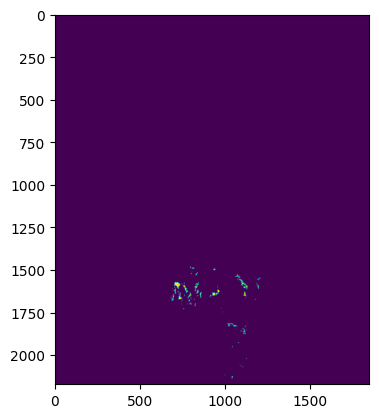

Wind suitability under baseline exclusions within california is 9514 square km


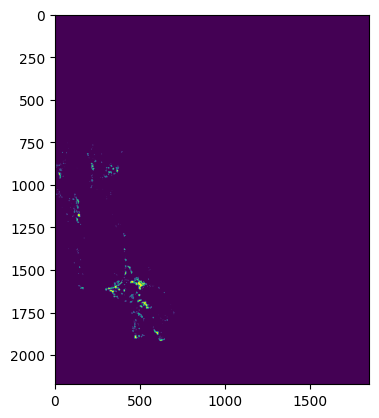

Wind suitability under baseline exclusions within colorado is 34116 square km


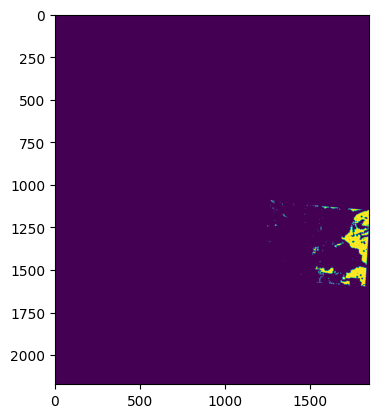

Wind suitability under baseline exclusions within idaho is 3329 square km


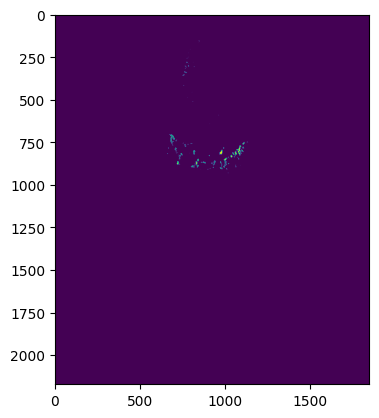

Wind suitability under baseline exclusions within montana is 95935 square km


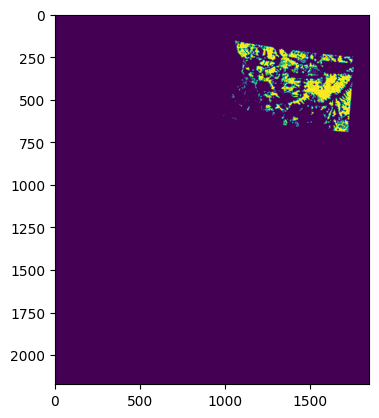

Wind suitability under baseline exclusions within new_mexico is 53510 square km


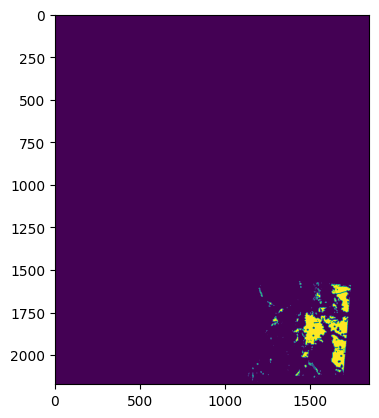

Wind suitability under baseline exclusions within nevada is 5545 square km


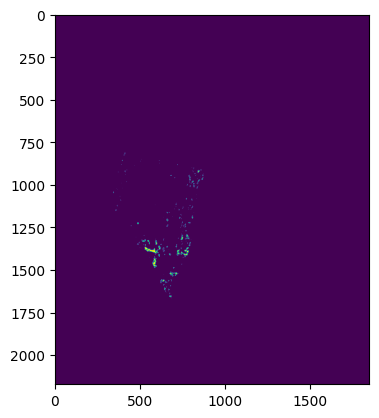

Wind suitability under baseline exclusions within oregon is 6434 square km


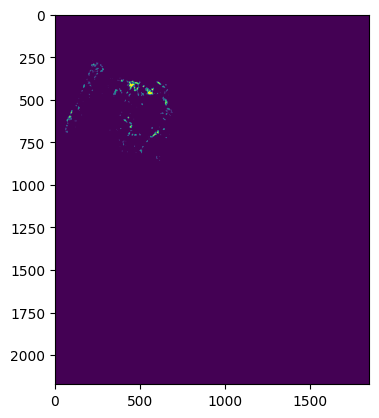

Wind suitability under baseline exclusions within utah is 2860 square km


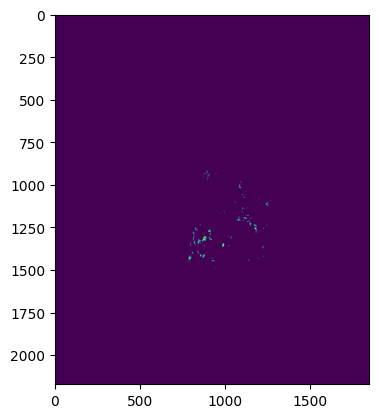

Wind suitability under baseline exclusions within washington is 5392 square km


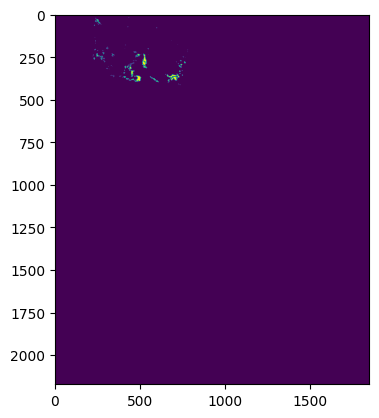

Wind suitability under baseline exclusions within wyoming is 74324 square km


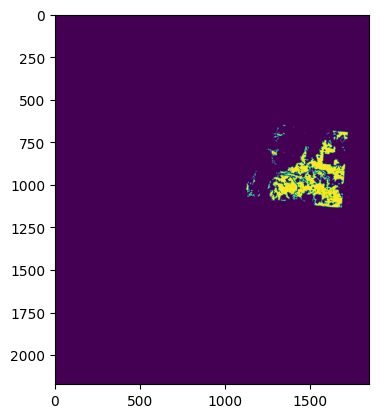

In [6]:
exclusion_list = []
tech_type = 'Wind'
analysis_name = 'baseline'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=True)

## DAC areas excluded

In [7]:
exclusion_list = [dac_raster_path]
tech_type = 'Wind'
analysis_name = 'dac'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

Wind suitability under dac exclusions within arizona is 1371 square km
Wind suitability under dac exclusions within california is 4789 square km
Wind suitability under dac exclusions within colorado is 14401 square km
Wind suitability under dac exclusions within idaho is 1075 square km
Wind suitability under dac exclusions within montana is 46731 square km
Wind suitability under dac exclusions within new_mexico is 4687 square km
Wind suitability under dac exclusions within nevada is 4545 square km
Wind suitability under dac exclusions within oregon is 2122 square km
Wind suitability under dac exclusions within utah is 2048 square km
Wind suitability under dac exclusions within washington is 3102 square km
Wind suitability under dac exclusions within wyoming is 62770 square km


## Important farmland areas excluded

In [8]:
exclusion_list = [farm_raster_path]
tech_type = 'Wind'
analysis_name = 'farmland'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

Wind suitability under farmland exclusions within arizona is 5477 square km
Wind suitability under farmland exclusions within california is 9129 square km
Wind suitability under farmland exclusions within colorado is 30713 square km
Wind suitability under farmland exclusions within idaho is 3309 square km
Wind suitability under farmland exclusions within montana is 81764 square km
Wind suitability under farmland exclusions within new_mexico is 44208 square km
Wind suitability under farmland exclusions within nevada is 5545 square km
Wind suitability under farmland exclusions within oregon is 3766 square km
Wind suitability under farmland exclusions within utah is 2845 square km
Wind suitability under farmland exclusions within washington is 3406 square km
Wind suitability under farmland exclusions within wyoming is 73638 square km


## Areas surrounding natural areas excluded

### Areas within 1-km

In [9]:
exclusion_list = [env_1km_raster_path]
tech_type = 'Wind'
analysis_name = 'env_1km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

Wind suitability under env_1km exclusions within arizona is 4759 square km
Wind suitability under env_1km exclusions within california is 7281 square km
Wind suitability under env_1km exclusions within colorado is 33011 square km
Wind suitability under env_1km exclusions within idaho is 2950 square km
Wind suitability under env_1km exclusions within montana is 83647 square km
Wind suitability under env_1km exclusions within new_mexico is 51671 square km
Wind suitability under env_1km exclusions within nevada is 4910 square km
Wind suitability under env_1km exclusions within oregon is 5148 square km
Wind suitability under env_1km exclusions within utah is 2383 square km
Wind suitability under env_1km exclusions within washington is 4851 square km
Wind suitability under env_1km exclusions within wyoming is 67673 square km


### Areas within 5-km

In [10]:
exclusion_list = [env_5km_raster_path]
tech_type = 'Wind'
analysis_name = 'env_5km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

Wind suitability under env_5km exclusions within arizona is 3183 square km
Wind suitability under env_5km exclusions within california is 2861 square km
Wind suitability under env_5km exclusions within colorado is 28073 square km
Wind suitability under env_5km exclusions within idaho is 1680 square km
Wind suitability under env_5km exclusions within montana is 41428 square km
Wind suitability under env_5km exclusions within new_mexico is 44550 square km
Wind suitability under env_5km exclusions within nevada is 3411 square km
Wind suitability under env_5km exclusions within oregon is 2507 square km
Wind suitability under env_5km exclusions within utah is 1413 square km
Wind suitability under env_5km exclusions within washington is 2802 square km
Wind suitability under env_5km exclusions within wyoming is 41867 square km


### Areas within 10-km

In [11]:
exclusion_list = [env_10km_raster_path]
tech_type = 'Wind'
analysis_name = 'env_10km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

Wind suitability under env_10km exclusions within arizona is 1896 square km
Wind suitability under env_10km exclusions within california is 1047 square km
Wind suitability under env_10km exclusions within colorado is 20096 square km
Wind suitability under env_10km exclusions within idaho is 565 square km
Wind suitability under env_10km exclusions within montana is 14887 square km
Wind suitability under env_10km exclusions within new_mexico is 35648 square km
Wind suitability under env_10km exclusions within nevada is 2095 square km
Wind suitability under env_10km exclusions within oregon is 1090 square km
Wind suitability under env_10km exclusions within utah is 905 square km
Wind suitability under env_10km exclusions within washington is 1530 square km
Wind suitability under env_10km exclusions within wyoming is 20121 square km


## Combinations

#### DACs, Important Farmland, and Areas within 5km of Natural Areas Excluded

In [12]:
exclusion_list = [dac_raster_path, farm_raster_path, env_5km_raster_path]
tech_type = 'Wind'
analysis_name = 'dac_farm_env5km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

Wind suitability under dac_farm_env5km exclusions within arizona is 673 square km
Wind suitability under dac_farm_env5km exclusions within california is 1981 square km
Wind suitability under dac_farm_env5km exclusions within colorado is 11617 square km
Wind suitability under dac_farm_env5km exclusions within idaho is 786 square km
Wind suitability under dac_farm_env5km exclusions within montana is 18614 square km
Wind suitability under dac_farm_env5km exclusions within new_mexico is 3098 square km
Wind suitability under dac_farm_env5km exclusions within nevada is 2818 square km
Wind suitability under dac_farm_env5km exclusions within oregon is 363 square km
Wind suitability under dac_farm_env5km exclusions within utah is 1096 square km
Wind suitability under dac_farm_env5km exclusions within washington is 924 square km
Wind suitability under dac_farm_env5km exclusions within wyoming is 35729 square km


#### Important Farmland, and Areas within 5km of Natural Areas Excluded

In [13]:
exclusion_list = [farm_raster_path, env_5km_raster_path]
tech_type = 'Wind'
analysis_name = 'farm_env5km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

Wind suitability under farm_env5km exclusions within arizona is 3183 square km
Wind suitability under farm_env5km exclusions within california is 2781 square km
Wind suitability under farm_env5km exclusions within colorado is 25070 square km
Wind suitability under farm_env5km exclusions within idaho is 1666 square km
Wind suitability under farm_env5km exclusions within montana is 35522 square km
Wind suitability under farm_env5km exclusions within new_mexico is 36562 square km
Wind suitability under farm_env5km exclusions within nevada is 3411 square km
Wind suitability under farm_env5km exclusions within oregon is 1379 square km
Wind suitability under farm_env5km exclusions within utah is 1413 square km
Wind suitability under farm_env5km exclusions within washington is 1884 square km
Wind suitability under farm_env5km exclusions within wyoming is 41395 square km


#### Important Farmland, and Areas within 10km of Natural Areas Excluded

In [14]:
exclusion_list = [farm_raster_path, env_10km_raster_path]
tech_type = 'Wind'
analysis_name = 'farm_env10km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

Wind suitability under farm_env10km exclusions within arizona is 1896 square km
Wind suitability under farm_env10km exclusions within california is 1029 square km
Wind suitability under farm_env10km exclusions within colorado is 17792 square km
Wind suitability under farm_env10km exclusions within idaho is 556 square km
Wind suitability under farm_env10km exclusions within montana is 12845 square km
Wind suitability under farm_env10km exclusions within new_mexico is 28974 square km
Wind suitability under farm_env10km exclusions within nevada is 2095 square km
Wind suitability under farm_env10km exclusions within oregon is 548 square km
Wind suitability under farm_env10km exclusions within utah is 905 square km
Wind suitability under farm_env10km exclusions within washington is 1023 square km
Wind suitability under farm_env10km exclusions within wyoming is 19900 square km


________

# Solar PV

## Baseline Siting Availability

How much land is available for siting with no additional restrictions in each state?

In [15]:
exclusion_list = []
tech_type = 'Solar PV'
analysis_name = 'baseline'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

Solar PV suitability under baseline exclusions within arizona is 149468 square km
Solar PV suitability under baseline exclusions within california is 94422 square km
Solar PV suitability under baseline exclusions within colorado is 118782 square km
Solar PV suitability under baseline exclusions within idaho is 64018 square km
Solar PV suitability under baseline exclusions within montana is 200614 square km
Solar PV suitability under baseline exclusions within new_mexico is 201750 square km
Solar PV suitability under baseline exclusions within nevada is 106346 square km
Solar PV suitability under baseline exclusions within oregon is 60930 square km
Solar PV suitability under baseline exclusions within utah is 61940 square km
Solar PV suitability under baseline exclusions within washington is 60247 square km
Solar PV suitability under baseline exclusions within wyoming is 150777 square km


## DAC areas excluded

In [16]:
exclusion_list = [dac_raster_path]
tech_type = 'Solar PV'
analysis_name = 'dac'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

Solar PV suitability under dac exclusions within arizona is 46395 square km
Solar PV suitability under dac exclusions within california is 38251 square km
Solar PV suitability under dac exclusions within colorado is 58883 square km
Solar PV suitability under dac exclusions within idaho is 18522 square km
Solar PV suitability under dac exclusions within montana is 104611 square km
Solar PV suitability under dac exclusions within new_mexico is 23030 square km
Solar PV suitability under dac exclusions within nevada is 81135 square km
Solar PV suitability under dac exclusions within oregon is 11622 square km
Solar PV suitability under dac exclusions within utah is 34126 square km
Solar PV suitability under dac exclusions within washington is 32459 square km
Solar PV suitability under dac exclusions within wyoming is 127750 square km


## Important farmland areas excluded

In [17]:
exclusion_list = [farm_raster_path]
tech_type = 'Solar PV'
analysis_name = 'farmland'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

Solar PV suitability under farmland exclusions within arizona is 146345 square km
Solar PV suitability under farmland exclusions within california is 78597 square km
Solar PV suitability under farmland exclusions within colorado is 108230 square km
Solar PV suitability under farmland exclusions within idaho is 62934 square km
Solar PV suitability under farmland exclusions within montana is 168821 square km
Solar PV suitability under farmland exclusions within new_mexico is 179489 square km
Solar PV suitability under farmland exclusions within nevada is 106295 square km
Solar PV suitability under farmland exclusions within oregon is 28275 square km
Solar PV suitability under farmland exclusions within utah is 57113 square km
Solar PV suitability under farmland exclusions within washington is 32568 square km
Solar PV suitability under farmland exclusions within wyoming is 149870 square km


## Areas surrounding natural areas excluded

### Areas within 1-km

In [18]:
exclusion_list = [env_1km_raster_path]
tech_type = 'Solar PV'
analysis_name = 'env_1km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

Solar PV suitability under env_1km exclusions within arizona is 138003 square km
Solar PV suitability under env_1km exclusions within california is 77444 square km
Solar PV suitability under env_1km exclusions within colorado is 108317 square km
Solar PV suitability under env_1km exclusions within idaho is 54342 square km
Solar PV suitability under env_1km exclusions within montana is 169865 square km
Solar PV suitability under env_1km exclusions within new_mexico is 188217 square km
Solar PV suitability under env_1km exclusions within nevada is 95328 square km
Solar PV suitability under env_1km exclusions within oregon is 50877 square km
Solar PV suitability under env_1km exclusions within utah is 55520 square km
Solar PV suitability under env_1km exclusions within washington is 52188 square km
Solar PV suitability under env_1km exclusions within wyoming is 134216 square km


### Areas within 5-km

In [19]:
exclusion_list = [env_5km_raster_path]
tech_type = 'Solar PV'
analysis_name = 'env_5km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

Solar PV suitability under env_5km exclusions within arizona is 96083 square km
Solar PV suitability under env_5km exclusions within california is 35956 square km
Solar PV suitability under env_5km exclusions within colorado is 74108 square km
Solar PV suitability under env_5km exclusions within idaho is 24823 square km
Solar PV suitability under env_5km exclusions within montana is 73973 square km
Solar PV suitability under env_5km exclusions within new_mexico is 140879 square km
Solar PV suitability under env_5km exclusions within nevada is 58064 square km
Solar PV suitability under env_5km exclusions within oregon is 24900 square km
Solar PV suitability under env_5km exclusions within utah is 35567 square km
Solar PV suitability under env_5km exclusions within washington is 27573 square km
Solar PV suitability under env_5km exclusions within wyoming is 77349 square km


### Areas within 10-km

In [20]:
exclusion_list = [env_10km_raster_path]
tech_type = 'Solar PV'
analysis_name = 'env_10km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

Solar PV suitability under env_10km exclusions within arizona is 58685 square km
Solar PV suitability under env_10km exclusions within california is 12363 square km
Solar PV suitability under env_10km exclusions within colorado is 44812 square km
Solar PV suitability under env_10km exclusions within idaho is 7220 square km
Solar PV suitability under env_10km exclusions within montana is 22620 square km
Solar PV suitability under env_10km exclusions within new_mexico is 95623 square km
Solar PV suitability under env_10km exclusions within nevada is 31555 square km
Solar PV suitability under env_10km exclusions within oregon is 9672 square km
Solar PV suitability under env_10km exclusions within utah is 20191 square km
Solar PV suitability under env_10km exclusions within washington is 11489 square km
Solar PV suitability under env_10km exclusions within wyoming is 35279 square km


## Combinations

#### DACs, Important Farmland, and Areas within 5km of Natural Areas Excluded

In [21]:
exclusion_list = [dac_raster_path, farm_raster_path, env_5km_raster_path]
tech_type = 'Solar PV'
analysis_name = 'dac_farm_env5km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

Solar PV suitability under dac_farm_env5km exclusions within arizona is 29037 square km
Solar PV suitability under dac_farm_env5km exclusions within california is 11447 square km
Solar PV suitability under dac_farm_env5km exclusions within colorado is 33028 square km
Solar PV suitability under dac_farm_env5km exclusions within idaho is 5924 square km
Solar PV suitability under dac_farm_env5km exclusions within montana is 34122 square km
Solar PV suitability under dac_farm_env5km exclusions within new_mexico is 13895 square km
Solar PV suitability under dac_farm_env5km exclusions within nevada is 43722 square km
Solar PV suitability under dac_farm_env5km exclusions within oregon is 1582 square km
Solar PV suitability under dac_farm_env5km exclusions within utah is 19698 square km
Solar PV suitability under dac_farm_env5km exclusions within washington is 5980 square km
Solar PV suitability under dac_farm_env5km exclusions within wyoming is 66940 square km


#### Important Farmland, and Areas within 5km of Natural Areas Excluded

In [22]:
exclusion_list = [farm_raster_path, env_5km_raster_path]
tech_type = 'Solar PV'
analysis_name = 'farm_env5km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

Solar PV suitability under farm_env5km exclusions within arizona is 94923 square km
Solar PV suitability under farm_env5km exclusions within california is 28055 square km
Solar PV suitability under farm_env5km exclusions within colorado is 67459 square km
Solar PV suitability under farm_env5km exclusions within idaho is 24319 square km
Solar PV suitability under farm_env5km exclusions within montana is 63629 square km
Solar PV suitability under farm_env5km exclusions within new_mexico is 123471 square km
Solar PV suitability under farm_env5km exclusions within nevada is 58022 square km
Solar PV suitability under farm_env5km exclusions within oregon is 10776 square km
Solar PV suitability under farm_env5km exclusions within utah is 33048 square km
Solar PV suitability under farm_env5km exclusions within washington is 14369 square km
Solar PV suitability under farm_env5km exclusions within wyoming is 76781 square km


#### Important Farmland, and Areas within 10km of Natural Areas Excluded

In [23]:
exclusion_list = [farm_raster_path, env_10km_raster_path]
tech_type = 'Solar PV'
analysis_name = 'farm_env10km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

Solar PV suitability under farm_env10km exclusions within arizona is 58270 square km
Solar PV suitability under farm_env10km exclusions within california is 9345 square km
Solar PV suitability under farm_env10km exclusions within colorado is 40765 square km
Solar PV suitability under farm_env10km exclusions within idaho is 6999 square km
Solar PV suitability under farm_env10km exclusions within montana is 19598 square km
Solar PV suitability under farm_env10km exclusions within new_mexico is 82948 square km
Solar PV suitability under farm_env10km exclusions within nevada is 31536 square km
Solar PV suitability under farm_env10km exclusions within oregon is 4147 square km
Solar PV suitability under farm_env10km exclusions within utah is 19213 square km
Solar PV suitability under farm_env10km exclusions within washington is 6037 square km
Solar PV suitability under farm_env10km exclusions within wyoming is 35039 square km


___________

## Prepare Output

In [24]:
# convert output dictionary to dataframe
df = pd.DataFrame.from_dict({(i,j): output_dict[i][j] 
                           for i in output_dict.keys() 
                           for j in output_dict[i].keys()},
                       orient='index')

df = df.reset_index().rename(columns={'level_0':'region_name', 'level_1':'tech_name_simple'})

,region_name,tech_name_simple,baseline,dac,farmland,env_1km,env_5km,env_10km,dac_farm_env5km,farm_env5km,farm_env10km
0,arizona,Wind,5477,1371,5477,4759,3183,1896,673,3183,1896
1,arizona,Solar PV,149468,46395,146345,138003,96083,58685,29037,94923,58270
2,california,Wind,9514,4789,9129,7281,2861,1047,1981,2781,1029
3,california,Solar PV,94422,38251,78597,77444,35956,12363,11447,28055,9345
4,colorado,Wind,34116,14401,30713,33011,28073,20096,11617,25070,17792
5,colorado,Solar PV,118782,58883,108230,108317,74108,44812,33028,67459,40765
6,idaho,Wind,3329,1075,3309,2950,1680,565,786,1666,556
7,idaho,Solar PV,64018,18522,62934,54342,24823,7220,5924,24319,6999
8,montana,Wind,95935,46731,81764,83647,41428,14887,18614,35522,12845
9,montana,Solar PV,200614,104611,168821,169865,73973,22620,34122,63629,19598


### Collect land actually used by wind and solar in each experiment scenario

In [25]:
# collect infrastructure data
sitings_df = pd.read_csv(infrastucture_path)

# select new infrastructure sitings only
sitings_df = sitings_df[sitings_df.cerf_sited == 1]

# reduce to year of interest
sitings_df = sitings_df[sitings_df.sited_year <= year]

# select wind and solar only
sitings_df = sitings_df[sitings_df.tech_name_simple.isin(['Solar PV', 'Wind'])]

# collect the total land usage used by solar and wind by state and scenario
sitings_df = sitings_df[['scenario', 'region_name', 'tech_name_simple', 'xcoord']].groupby(['scenario', 'region_name', 'tech_name_simple'], 
                                                                                           as_index=False).count()
# shorten scenario names
sitings_df.scenario.replace('business_as_usual_ira_ccs_climate', 'bau_km', inplace=True)
sitings_df.scenario.replace('net_zero_ira_ccs_climate', 'clean_grid_km', inplace=True)

#Pivoting dataframe
sitings_df = pd.pivot_table(sitings_df, values='xcoord', index=['region_name', 'tech_name_simple'], columns=['scenario'], aggfunc=np.sum)
sitings_df = sitings_df.reset_index()
sitings_df = sitings_df.rename_axis(None, axis=1)

,region_name,tech_name_simple,bau_km,clean_grid_km
0,arizona,Solar PV,725,914
1,arizona,Wind,614,715
2,california,Solar PV,1398,2264
3,california,Wind,2025,3066
4,colorado,Solar PV,661,925
5,colorado,Wind,1095,1596
6,idaho,Solar PV,32,42
7,idaho,Wind,302,336
8,montana,Solar PV,221,388
9,montana,Wind,2141,2921


##### Combine dataframes and save to file

In [26]:
output_df = pd.merge(df, sitings_df, how='left', on=['region_name', 'tech_name_simple'])

In [28]:
# output file path
output_path = os.path.join(output_dir, f'suitability_analysis_{year}.csv')

output_df.to_csv(output_path, index=False)